# CNN

In [1]:
from pathlib import Path
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torch.amp import autocast
from torch import nn, optim
import copy
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.dataset import CnvDataset

Important paths:

In [3]:
git_root = Path('.')
data_root = git_root / 'data'
assert data_root.exists()

Defining paths for batch 1.

In [4]:
dataset_root_val = data_root / 'embeddings' / 'batch_1' / 'val'
dataset_root_train = data_root / 'embeddings' / 'batch_1' / 'train'
dataset_root_test = data_root / 'embeddings' / 'batch_1' / 'test'

In [5]:
b1_val_path = data_root / 'splits' / 'batch1_val_filtered.tsv'
b1_val_df = pd.read_csv(b1_val_path, sep='\t')
b1_val_df

b1_train_path = data_root / 'splits' / 'batch1_training_filtered.tsv'
b1_train_df = pd.read_csv(b1_train_path, sep='\t')
b1_train_df

# b1_test_path = data_root / 'splits' / 'batch1_test_filtered.tsv'
# b1_test_df = pd.read_csv(b1_test_path, sep='\t')
# b1_test_df

,barcode,gene_id,expression_count,classification
0,AAACCAACATGTCAGC-1,ENSG00000269113,0.749940,low
1,AAACCAACATGTCAGC-1,ENSG00000229956,1.173642,high
2,AAACCAACATGTCAGC-1,ENSG00000237505,0.749940,low
3,AAACCAACATGTCAGC-1,ENSG00000188641,0.749940,low
4,AAACCAACATGTCAGC-1,ENSG00000162636,0.749940,low
...,...,...,...,...
59336,TTTGTTGGTGCCGCAA-1,ENSG00000198938,2.220852,high
59337,TTTGTTGGTGCCGCAA-1,ENSG00000198840,1.968703,high
59338,TTTGTTGGTGCCGCAA-1,ENSG00000198886,1.116385,high
59339,TTTGTTGGTGCCGCAA-1,ENSG00000198786,1.406267,high


In [6]:
b1_val_dataset = CnvDataset(root=dataset_root_val, data_df=b1_val_df)

b1_train_dataset = CnvDataset(root=dataset_root_train, data_df=b1_train_df)

# b1_test_dataset = CnvDataset(root=dataset_root_test, data_df=b1_test_df)

Using 51 barcodes
Using 1093 genes
No embedding files for 988 data points in data/embeddings/batch_1/val/single_gene_barcode!
Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in data/embeddings/batch_1/train/single_gene_barcode!


In [7]:
%load_ext tensorboard
%tensorboard --logdir=./log/tensorboard --port 6006

Launching TensorBoard...

In [ ]:
# define hparams
hparams = {
    'batch_size': 32,
    'epochs': 20,
    'lr': 1e-3
}
sequ_len = 10000 ##### add correct one

epochs = 20

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [10]:
def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)

def train_model(model, train_loader, val_loader, tb_logger, name='default'):
    """
    Model training function.
    """
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=hparams.get('lr', 1e-3)
    )
    criterion = nn.BCEWithLogitsLoss()
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    epochs = hparams.get('epochs', 3)

    model = model.to(device)

    validation_loss = 0

    # Riccardo
    best_val_loss = float('inf')
    
    train_losses_avg = []
    val_losses_avg = []
    best_model = None

    for epoch in range(epochs):

        # training
        model.train()

        train_loss = 0
        train_losses = []
        
        train_loop = create_tqdm_bar(
            train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]'
            )
        for train_i, (stacked_inputs_batch, y_batch) in train_loop:

            stacked_inputs_batch = stacked_inputs_batch.to(device)
            y_batch = y_batch.to(device) # , non_blocking=True
            #stacked_inputs_batch = stacked_inputs_batch.unsqueeze(0)

            optimizer.zero_grad()

            # with autocast(device_type=device):   
            outputs = model(stacked_inputs_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            train_loss += loss.item()
            train_losses.append(loss.item())
            
            # Update the progress bar.
            train_loop.set_postfix(
                curr_train_loss = "{:.8f}".format(train_loss / (train_i + 1)), 
                val_loss = "{:.8f}".format(validation_loss)
                )

            # Update the tensorboard logger.
            tb_logger.add_scalar(
                f'CNV_model_{name}/train_loss', loss.item(), 
                epoch * len(train_loader) + train_i
                )
            
        avg_train_loss = sum(train_losses) / len(train_losses)
        train_losses_avg.append(avg_train_loss)
    
        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")
    
        # validation
        model.eval()
        val_losses = []
        val_loss = 0
        val_loop = create_tqdm_bar(
            val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]'
            )
        with torch.no_grad():
            for val_i, (stacked_inputs_batch, y_batch) in val_loop:

                stacked_inputs_batch = stacked_inputs_batch.to(device)
                y_batch = y_batch.to(device) # , non_blocking=True
                #stacked_inputs_batch = stacked_inputs_batch.unsqueeze(0)

                # with torch.no_grad(), autocast():
                y_pred = model(stacked_inputs_batch)
                loss = criterion(y_pred, y_batch)
                val_losses.append(loss.item())
                val_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(
                    val_loss = "{:.8f}".format(validation_loss / (val_i + 1))
                    )

                # Update the tensorboard logger.
                tb_logger.add_scalar(
                    f'CNV_model_{name}/val_loss', loss.item(), 
                    epoch * len(val_loader) + val_i
                    )

            avg_val_loss = sum(val_losses) / len(val_losses)
            val_losses_avg.append(avg_val_loss)
            # print(f'Epoch {epoch+1}, Val loss: {avg_val_loss}')
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = copy.deepcopy(model.state_dict())
        
        # This value is used for the progress bar of the training loop.
        validation_loss /= len(val_loader)

    plt.plot(train_losses_avg[1:], label='Train Loss')
    plt.plot(val_losses_avg[1:], label='Val Loss')
    plt.legend()
    plt.show()
            
    return avg_val_loss, best_model

In [11]:
def evaluate_model(model, dataset):
    model.eval()
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0
    for dna_embedding, target in dataloader:
        dna_embedding, target = dna_embedding.to(device), target.to(device)
        y_hat = model(dna_embedding)
        loss += criterion(target, y_hat).item()
    return 1.0 / (2 * (loss / len(dataloader)))

Setup tensorboard logging for training.

In [14]:
from torch.utils.tensorboard import SummaryWriter
tb_log_path = Path('log') / 'tensorboard'
run_number = len([
    d for d in tb_log_path.iterdir() if d.is_dir() and d.name.startswith('run_')
    ])
tb_log_path = tb_log_path / '_'.join(['run', str(run_number)])
tb_logger = SummaryWriter(tb_log_path)

Setup data and hparams for training.

In [15]:
batch_size = hparams.get('batch_size', 32)
train_loader = DataLoader(b1_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(b1_val_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(b1_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Select model.

In [16]:
from src.network.chromosome_cnn import ChromosomeCNN

In [17]:
cnn_model = ChromosomeCNN(input_dim=7, seq_len=10_000, output_dim=1)

Validation Epoch [3/3]: 100%|██████████████████████████████████████████████████████████████████| 249/249 [02:44<00:00,  1.51it/s, val_loss=0.00000000]


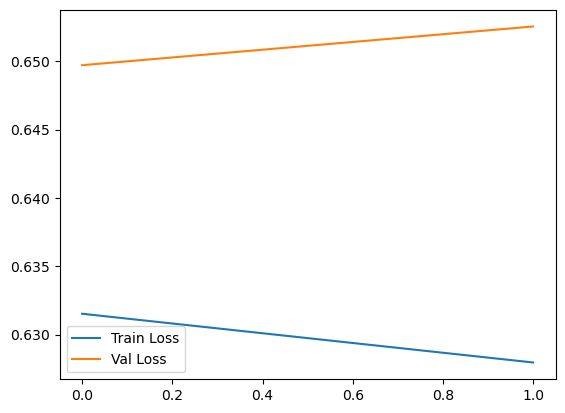

(0.6525476136839533,
 OrderedDict([('conv1.weight',
               tensor([[[ 1.1174e-01,  9.0178e-02, -1.0909e-01, -6.1994e-02,  2.4155e-01],
                        [-1.5410e-01, -2.7498e-01, -2.8289e-01, -1.2038e-01, -9.8645e-02],
                        [-2.0542e-01, -2.1390e-01,  3.7486e-01,  6.6523e-02, -2.8439e-01],
                        ...,
                        [ 1.7616e-01, -1.1232e-02, -2.6815e-02,  1.3544e-01, -2.5793e-02],
                        [-4.7583e-02, -1.6473e-01, -1.9150e-01, -3.7817e-02, -1.9065e-01],
                        [-1.2699e-01, -1.2472e-01, -7.1237e-02, -2.3430e-02, -2.7927e-04]],
               
                       [[ 1.4906e-01,  9.0318e-02,  8.9818e-02,  2.4933e-02, -5.9392e-02],
                        [-1.7466e-01, -3.7642e-02, -1.4464e-01,  1.6248e-01,  1.0574e-01],
                        [ 9.7295e-02,  1.3669e-01,  2.5616e-02, -1.0294e-01, -1.5016e-01],
                        ...,
                        [-1.6840e-01,  2.4106e-02,  1.

In [18]:
avg_val_loss, best_model = train_model(cnn_model, train_loader, val_loader, tb_logger, name='ChromosomeCNN')

In [ ]:
evaluate_model(cnn_model, b1_val_dataset)

In [13]:
def ablation_study_evaluation(train_loader, val_loader, test_loader, channel_variable_counts, seq_len, num_epochs):

    print("Training with all channels intact...")
    num_channels = 7
    
    full_train_loader = full_study(train_loader)
    full_val_loader = full_study(val_loader)
    full_test_loader = full_study(test_loader)
    
    model = ChromosomeCNN(input_dim = num_channels, seq_len = seq_len, output_dim = 1).to(device)
    baseline_loss = train_(model, full_train_loader, full_val_loader, num_epochs)
    
    torch.save({
        'model_state_dict': model.state_dict(),
    }, 'baseline_model.pth')
    
    baseline_test = test_model("baseline_model.pth", full_test_loader, num_channels, seq_len)

    for channel_idx in range(3):
        print(f"\nAblating channel {channel_idx}...")
        
        remaining_channels = [i for i in range(3) if i != channel_idx]
        remaining_variables = sum(channel_variable_counts[i] for i in remaining_channels)
        print("remaing variables", remaining_variables)
        
        model = ChromosomeCNN(input_dim = remaining_variables, seq_len = seq_len, output_dim = 1).to(device)
        
        ablated_train_loader = create_ablated_dataloader(train_loader, channel_idx, channel_variable_counts)
        ablated_val_loader = create_ablated_dataloader(val_loader, channel_idx, channel_variable_counts)
        ablated_test_loader = create_ablated_dataloader(test_loader, channel_idx, channel_variable_counts)

        
        model_ablated = ChromosomeCNN(input_dim=remaining_variables, seq_len=seq_len, output_dim=1).to(device)
        ablated_model_name = f"ablated_model_channel_{channel_idx}"
        
        ablated_loss = train_(model_ablated, ablated_train_loader, ablated_val_loader, epochs)#, ablated_model_name)
        
        ablated_model_filename = f'ablated_model_channel_{channel_idx}.pth'
        torch.save({
            'model_state_dict': model_ablated.state_dict(),
        }, ablated_model_filename)

        results = {}
        results[f"Ablated Channel {channel_idx}"] = test_model(
            f"{ablated_model_name}.pth", ablated_test_loader, remaining_variables, seq_len
        )
        
        
        print(f"Loss after ablating channel {channel_idx}: {ablated_loss:.4f}")
        print(f"Performance drop: {baseline_loss - ablated_loss:.4f}")

In [14]:
def test_model(model_path, test_loader, total_variables, seq_len):

    model = ChromosomeCNN(input_dim=total_variables, seq_len=seq_len, output_dim=1).to(device)
    checkpoint = torch.load(model_path)
    
    input_tensor = torch.zeros(1, model.input_dim, model.seq_len).to(device)
    model(input_tensor)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.eval()

    criterion = nn.BCEWithLogitsLoss()
    test_losses = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for stacked_inputs_batch, y_batch in test_loader:
            stacked_inputs_batch = stacked_inputs_batch.to(device)
            y_batch = y_batch.to(device, non_blocking=True)
            #stacked_inputs_batch = stacked_inputs_batch.unsqueeze(0)

            with autocast():
                outputs = model(stacked_inputs_batch)
                loss = criterion(outputs, y_batch)
                test_losses.append(loss.item())

                all_predictions.append(outputs.cpu().numpy())
                all_labels.append(y_batch.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"Test MSE: {avg_test_loss:.4f}")

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    probabilities = 1 / (1 + np.exp(-all_predictions))  # Sigmoid function
    predicted_classes = (probabilities >= 0.5).astype(int)  # Convert to 0 or 1 based on threshold

    # Compute accuracy and other metrics
    accuracy = accuracy_score(all_labels, predicted_classes)
    precision = precision_score(all_labels, predicted_classes)
    recall = recall_score(all_labels, predicted_classes)
    f1 = f1_score(all_labels, predicted_classes)
    auc = roc_auc_score(all_labels, probabilities)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    
    return avg_test_loss

In [ ]:
embedding_dim = 4  
cnv_dim = 2        
chromatin_dim = 1  
expression_dim = 1
seq_len=10_000

ablation_study_evaluation(train_loader, val_loader, test_loader, channel_variable_counts=[embedding_dim, cnv_dim, chromatin_dim], seq_len=seq_len, num_epochs=epochs)

Training with all channels intact...


/tmp/ipykernel_4119696/1265460881.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
#model.eval()
#correct = 0
#total = 0
#with torch.no_grad():
#    for X_batch, y_batch in test_loader:
#        X_batch, y_batch = X_batch.to(device).unsqueeze(1), y_batch.to(device).unsqueeze(1)
#        outputs = model(X_batch)
#        predictions = (outputs > 0.5).float()
#        correct += (predictions == y_batch).sum().item()
#        total += y_batch.size(0)

#accuracy = correct / total
#print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
#model.load_state_dict(best_model)
#model.eval()
#test_losses = []
#y_preds = []
#y_actuals = []

#scaler = GradScaler()

#for X_batch, cnv_batch, y_batch in test_loader:

#    X_batch = X_batch.unsqueeze(1).to(device, non_blocking=True)
#    cnv_batch = cnv_batch.to(device)
#    y_batch = y_batch.to(device, non_blocking=True)
    
#    with torch.no_grad(), autocast():
#        y_pred = model(X_batch, cnv_batch)
#        lossV = criterion(y_pred, y_batch)
        
#        y_preds.extend(y_pred.cpu().numpy())
#        y_actuals.extend(y_batch.cpu().numpy())
#        test_losses.append(lossV.item())

#avg_test_loss = sum(test_losses) / len(test_losses)
#print(f'Test MSE: {avg_test_loss}')

In [ ]:
def model_summary(model):
    print("Model Summary:")
    print("{:<50} {:<30} {:<15} {:<15}".format("Layer Name", "Shape", "Parameters", "Trainable"))
    print("-" * 110)
    total_params = 0
    total_trainable_params = 0
    lm_params = 0
    lm_trainable_params = 0
    lm_layers = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params += param
        # Check if the parameter is trainable
        trainable = parameter.requires_grad
        trainable_param = param if trainable else 0
        total_trainable_params += trainable_param
        print("{:<50} {:<30} {:<15} {:<15}".format(name, str(parameter.size()), param, trainable_param))
    print("-" * 110)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {total_trainable_params}")

#model_summary(model)